In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import uuid
import glob

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = "data/train_image"
TRAIN_MASK_PATH = "data/train_mask"
VAL_PATH = "data/val_image"
VAL_MASK_PATH = "data/val_mask"

In [4]:
for image_name in glob.glob(os.path.join(TRAIN_PATH, "class_0", "*")):
    old_name = image_name.split("/")[-1].replace(".jpg", "")
    new_name = uuid.uuid4().hex
#     print(image_name, image_name.replace(old_name, new_name))
#     print(image_name.replace("train_image", "train_mask"), image_name.replace(old_name, new_name).replace("train_image", "train_mask"))
    os.rename(image_name, image_name.replace(old_name, new_name))
    os.rename(image_name.replace("train_image", "train_mask").replace("jpg", "png"), 
              image_name.replace(old_name, new_name).replace("train_image", "train_mask").replace("jpg", "png"))

In [5]:
for image_name in glob.glob(os.path.join(VAL_PATH, "class_0", "*")):
    old_name = image_name.split("/")[-1].replace(".jpg", "")
    new_name = uuid.uuid4().hex
#     print(image_name, image_name.replace(old_name, new_name))
#     print(image_name.replace("train_image", "train_mask"), image_name.replace(old_name, new_name).replace("train_image", "train_mask"))
    os.rename(image_name, image_name.replace(old_name, new_name))
    os.rename(image_name.replace("val_image", "val_mask").replace("jpg", "png"), 
              image_name.replace(old_name, new_name).replace("val_image", "val_mask").replace("jpg", "png"))

## Data Generator

In [6]:
BATCH_SIZE = 64

In [7]:
data_gen_args = dict(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.3,
#     horizontal_flip =1, 
#     vertical_flip =1,
#     validation_split=VAL_SPLIT,
    rescale =1./255
)

mask_gen_args = dict(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.3,
#     horizontal_flip =1,
#     vertical_flip =1,
#     validation_split=0.1,
#     rescale =1./255
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

seed = 1

image_generator = image_datagen.flow_from_directory(
    TRAIN_PATH,
    class_mode=None,
    seed=seed,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

mask_generator = mask_datagen.flow_from_directory(
    TRAIN_MASK_PATH,
    class_mode=None,
    seed=seed,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

train_generator = (pair for pair in zip(image_generator, mask_generator))
TRAIN_STEP = image_generator.n // BATCH_SIZE
TRAIN_STEP

Found 1896 images belonging to 1 classes.
Found 1896 images belonging to 1 classes.


29

In [8]:
image_generator = image_datagen.flow_from_directory(
    VAL_PATH,
    class_mode=None,
    seed=seed,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

mask_generator = mask_datagen.flow_from_directory(
    VAL_MASK_PATH,
    class_mode=None,
    seed=seed,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

valid_generator = (pair for pair in zip(image_generator, mask_generator))
VAL_STEP = image_generator.n // BATCH_SIZE
VAL_STEP

Found 475 images belonging to 1 classes.
Found 475 images belonging to 1 classes.


7

## U-net

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
base_model = tf.keras.applications.DenseNet121(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'conv1/relu',   # 128x128
    'conv2_block6_1_relu',   # 64x64
    'conv3_block12_1_relu',   # 32x32
    'conv4_block24_1_relu',  # 16x16
    'conv5_block16_2_conv',      # 8x8
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, 
            size,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [11]:
up_stack = [
    upsample(512, 3),  # 8x8 -> 16x16
    upsample(256, 3),  # 16x16 -> 32x32
    upsample(128, 3),  # 32x32 -> 64x64
    upsample(64, 3),   # 64x64 -> 128x128
]

In [12]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same'
    )
    
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
model = unet_model(3)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
# tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[1][3]                

## Train

In [15]:
EPOCH = 20

In [16]:
RES_DIR = "result"
MODEL_NAME = "unet_mobilenet_128"
if not os.path.exists(os.path.join(RES_DIR, MODEL_NAME)):
    os.makedirs(os.path.join(RES_DIR, MODEL_NAME))

In [46]:
# earlystopper = EarlyStopping(patience=5, verbose=1)
# checkpointer = ModelCheckpoint(os.path.join(RES_DIR, MODEL_NAME, "model.h5"), verbose=1, save_best_only=True)

In [ ]:
history = model.fit_generator(

    train_generator,
    steps_per_epoch=TRAIN_STEP,
    
    validation_data=valid_generator,
    validation_steps=VAL_STEP,
    
    epochs=EPOCH,
#     callbacks=[earlystopper, checkpointer]

)

Epoch 1/20
29/29 [==============================] - 12s 420ms/step - loss: 0.7261 - acc: 0.7027 - val_loss: 0.8501 - val_acc: 0.7596
Epoch 2/20
29/29 [==============================] - 10s 336ms/step - loss: 0.3739 - acc: 0.8656 - val_loss: 0.5158 - val_acc: 0.8188
Epoch 3/20
29/29 [==============================] - 10s 341ms/step - loss: 0.3183 - acc: 0.8823 - val_loss: 0.4524 - val_acc: 0.8310
Epoch 4/20
29/29 [==============================] - 10s 343ms/step - loss: 0.2972 - acc: 0.8880 - val_loss: 0.3833 - val_acc: 0.8513
Epoch 5/20
29/29 [==============================] - 10s 343ms/step - loss: 0.2778 - acc: 0.8948 - val_loss: 0.4059 - val_acc: 0.8429
Epoch 6/20
29/29 [==============================] - 10s 342ms/step - loss: 0.2632 - acc: 0.8996 - val_loss: 0.3429 - val_acc: 0.8675
Epoch 7/20
29/29 [==============================] - 10s 341ms/step - loss: 0.2514 - acc: 0.9041 - val_loss: 0.3195 - val_acc: 0.8765
Epoch 8/20
29/29 [==============================] - 10s 338ms/step - 

In [51]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(20, 12))
    # Acc
    plt.subplot(221)
    plt.plot(history.history['acc'],'o-', label = "Train Acc")
    plt.plot(history.history['val_acc'], 'o-', label = "Val Acc")
    plt.title("Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    # Loss
    plt.subplot(222)
    plt.plot(history.history['loss'],'o-', label = "Train Loss")
    plt.plot(history.history['val_loss'], 'o-', label = "Val Loss")
    plt.title("Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()

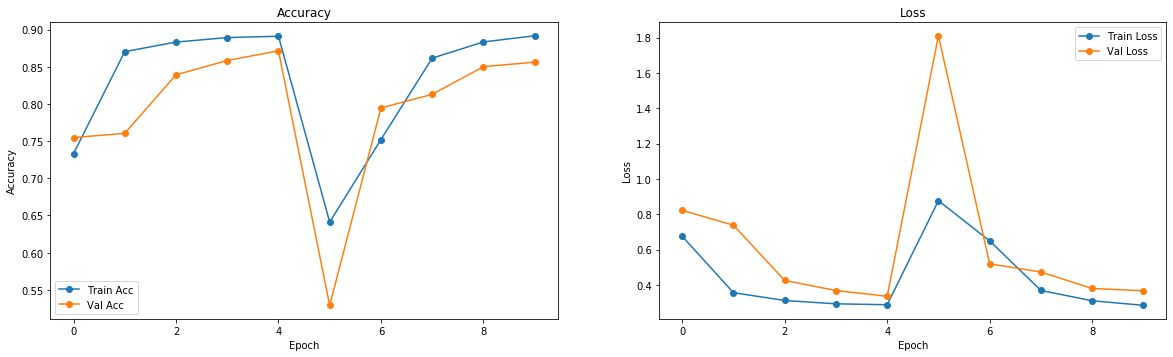

In [52]:
plot_accuracy_loss(history)
plt.show()

In [53]:
plot_accuracy_loss(history)
plt.savefig(os.path.join(RES_DIR, MODEL_NAME, "acc_loss.png"))
plt.close()